In [1]:
# pip install -r requirements.txt

# pip install --upgrade numpy

# conda install -c conda-forge nglview 
import nglview as nv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yaml
import json

import tensorflow as tf

from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

# Посмотрим на распределение таргета

In [3]:
targets = pd.read_csv('data/targets.csv')

targets.head()

,_id,band_gap
0,6141cf0f51c1cbd9654b8870,1.0843
1,6141cf1051c1cbd9654b8872,1.1102
2,6141cf11cc0e69a0cf28ab35,1.1484
3,6141cf11b842c2e72e2f2d48,1.8068
4,6141cf11ae4fb853db2e3f14,0.3600


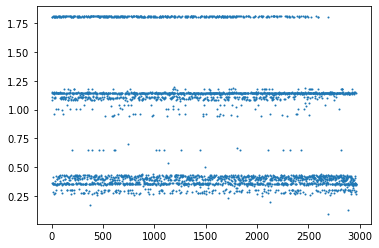

In [4]:
plt.scatter(np.arange(len(targets.band_gap)), targets.band_gap, s=1)

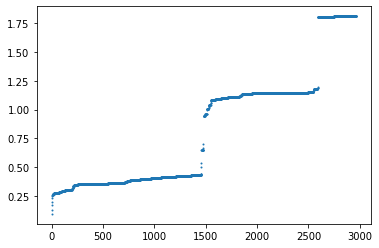

In [5]:
plt.scatter(np.arange(len(targets.band_gap)), sorted(targets.band_gap), s=1)

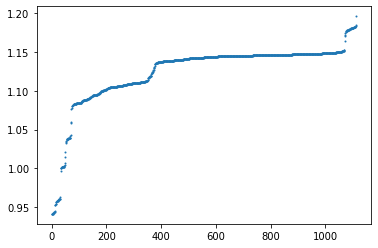

In [6]:
plt.scatter(np.arange(len(targets[(targets.band_gap < 1.25) & (targets.band_gap > 0.75)].band_gap)), 
            sorted(targets[(targets.band_gap < 1.25) & (targets.band_gap > 0.75)].band_gap), s=1)

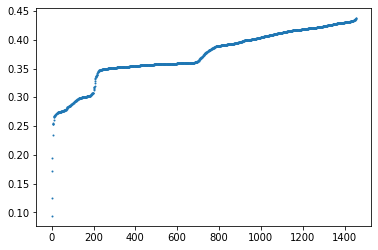

In [58]:
plt.scatter(np.arange(len(targets[targets.band_gap < 0.5].band_gap)), sorted(targets[targets.band_gap < 0.5].band_gap), s=1)

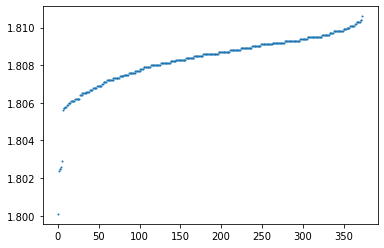

In [108]:
plt.scatter(np.arange(len(targets[targets.band_gap > 1.5].band_gap)), sorted(targets[targets.band_gap > 1.5].band_gap), s=1)

# Посмотрим на данные

In [3]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)


def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

    return data

In [4]:
data = prepare_dataset('data/dichalcogenides_public/')
data

,structures,targets
6142031bee0a3fd43fb47e23,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2754
6141d46031cf3ef3d4a9eee8,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2839
614211354e27a1844a5f05b4,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1450
614346254e27a1844a5f0a14,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1405
6141e2eb9cbada84a8676ab7,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.8092
...,...,...
614253223ac25c70a5c6cb7d,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4256
614235e04e27a1844a5f06c2,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1441
6143bc5931cf3ef3d4a9f792,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3925
61429809ee0a3fd43fb47f6f,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3511


In [80]:
data['class'] = -1
data.loc[(data.targets > 0.25) & (data.targets < 0.5), 'class'] = 0
data.loc[(data.targets > 0.75) & (data.targets < 1.25), 'class'] = 1
data.loc[(data.targets > 1.5), 'class'] = 2
data

,structures,targets,class
6142031bee0a3fd43fb47e23,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2754,0
6141d46031cf3ef3d4a9eee8,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2839,0
614211354e27a1844a5f05b4,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1450,1
614346254e27a1844a5f0a14,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1405,1
6141e2eb9cbada84a8676ab7,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.8092,2
...,...,...,...
614253223ac25c70a5c6cb7d,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4256,0
614235e04e27a1844a5f06c2,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1441,1
6143bc5931cf3ef3d4a9f792,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3925,0
61429809ee0a3fd43fb47f6f,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3511,0


In [81]:
data['class'].value_counts()

 0    1451
 1    1114
 2     374
-1      27
Name: class, dtype: int64

In [83]:
n = 10
sample = data[data['class'] == 2].sample(n)

other = data[data['targets'] != 2].sample(n)

In [85]:
sample.structures[0]

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: Mo (0.0000, 1.8419, 3.7198) [0.0417, 0.0833, 0.2500]
PeriodicSite: Mo (-1.5952, 4.6048, 3.7198) [0.0417, 0.2083, 0.2500]
PeriodicSite: Mo (-3.1903, 7.3677, 3.7198) [0.0417, 0.3333, 0.2500]
PeriodicSite: Mo (-4.7855, 10.1306, 3.7198) [0.0417, 0.4583, 0.2500]
PeriodicSite: Mo (-6.3806, 12.8935, 3.7198) [0.0417, 0.5833, 0.2500]
PeriodicSite: Mo (-7.9758, 15.6564, 3.7198) [0.0417, 0.7083, 0.2500]
PeriodicSite: Mo (-11.1661, 21.1822, 3.7198) [0.0417, 0.9583, 0.2500]
PeriodicSite: Mo (3.1903, 1.8419, 3.7198) [0.1667, 0.0833, 0.2500]
PeriodicSite: Mo (1.5952, 4.6048, 3.7198) [0.1667, 0.2083, 0.2500]
PeriodicSite: Mo (0.0000, 7.3677, 3.7198) [0.1667, 0.3333, 0.2500]
PeriodicSite: Mo (-1.5952, 10.1306, 3

In [45]:
type(sample.structures[0].sites[0])

pymatgen.core.sites.PeriodicSite

In [53]:
sample.structures[0].sites[0]

PeriodicSite: Mo (0.0000, 1.8419, 3.7198) [0.0417, 0.0833, 0.2500]

In [1]:
vars(sample.structures[0].sites[0])

NameError: name 'sample' is not defined

# что за магические 3 числа  в квадратных скобках????

# Визуализация структур

In [61]:
nv.show_pymatgen(sample.structures[0])

NGLWidget()

In [41]:
view = nv.show_pymatgen(other.structures[9])
view.add_unitcell()
view

NGLWidget()

# Получение хим состава

In [134]:
from collections import defaultdict

def decompose(structure):
    result = defaultdict(int)
    for site in structure.sites:
        result[site.species.formula] += 1
    return result

In [135]:
# sample = data[data['class'] == 2]

# composition_2 = []
# for i in range(len(sample)):
#     current_composition = decompose(sample.structures[i])
#     if current_composition not in composition_2:
#         composition_2.append(current_composition)
        
# cnt = [0, 0, 0, 0]
# for i in range(len(sample)):
#     current_composition = decompose(sample.structures[i])
#     if current_composition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}):
#         cnt[0] += 1
#     elif current_composition == defaultdict(int, {'Mo1': 64, 'Se1': 2, 'S1': 126}):
#         cnt[1] += 1   
#     elif current_composition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 128}):
#         cnt[2] += 1
#     elif current_composition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 127}):
#         cnt[3] += 1
    
# for cmp, cnt_i in zip(composition_2, cnt):
#     print(cnt_i, cmp.items())

In [128]:
data['decomposition'] = data.structures.apply(decompose)
data['len_of_decomposition'] = data['decomposition'].apply(len)

data.head()

,structures,targets,class,decomposition,len_of_decomposition
6142031bee0a3fd43fb47e23,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2754,0,"{'Mo1': 63, 'Se1': 2, 'S1': 126}",3
6141d46031cf3ef3d4a9eee8,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.2839,0,"{'Mo1': 63, 'Se1': 1, 'S1': 126}",3
614211354e27a1844a5f05b4,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1450,1,"{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}",4
614346254e27a1844a5f0a14,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1405,1,"{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}",4
6141e2eb9cbada84a8676ab7,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.8092,2,"{'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}",4


In [193]:
data['decomposition'].value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}    716
{'Mo1': 63, 'Se1': 1, 'S1': 126}             702
{'Mo1': 63, 'W1': 1, 'S1': 126}              380
{'Mo1': 63, 'Se1': 2, 'S1': 126}             377
{'Mo1': 63, 'S1': 126}                       363
{'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}    360
{'Mo1': 64, 'Se1': 1, 'S1': 126}              18
{'Mo1': 64, 'S1': 126}                        12
{'Mo1': 64, 'Se1': 2, 'S1': 126}               8
{'Mo1': 63, 'S1': 127}                         8
{'Mo1': 63, 'W1': 1, 'S1': 127}                8
{'Mo1': 63, 'Se1': 1, 'S1': 127}               7
{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 127}      5
{'Mo1': 63, 'W1': 1, 'S1': 128}                1
{'Mo1': 63, 'S1': 128}                         1
Name: decomposition, dtype: int64

In [129]:
data[data['class'] == 2]['len_of_decomposition'].value_counts()

4    365
3      9
Name: len_of_decomposition, dtype: int64

In [130]:
data[data['class'] == 1]['len_of_decomposition'].value_counts()

4    716
3    387
2     11
Name: len_of_decomposition, dtype: int64

In [136]:
data[data['class'] == 0]['len_of_decomposition'].value_counts()

3    1083
2     368
Name: len_of_decomposition, dtype: int64

In [138]:
data[data['class'] == 2]['decomposition'].value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}    360
{'Mo1': 64, 'Se1': 2, 'S1': 126}               8
{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 127}      5
{'Mo1': 63, 'W1': 1, 'S1': 128}                1
Name: decomposition, dtype: int64

In [133]:
data[data['class'] == 1]['decomposition'].value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}    716
{'Mo1': 63, 'W1': 1, 'S1': 126}              361
{'Mo1': 64, 'Se1': 1, 'S1': 126}              18
{'Mo1': 64, 'S1': 126}                        11
{'Mo1': 63, 'W1': 1, 'S1': 127}                8
Name: decomposition, dtype: int64

In [139]:
data[data['class'] == 0]['decomposition'].value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'Se1': 1, 'S1': 126}    699
{'Mo1': 63, 'Se1': 2, 'S1': 126}    377
{'Mo1': 63, 'S1': 126}              359
{'Mo1': 63, 'S1': 127}                8
{'Mo1': 63, 'Se1': 1, 'S1': 127}      7
{'Mo1': 63, 'S1': 128}                1
Name: decomposition, dtype: int64

# НАБЛЮДЕНИЯ


class2:
- почти все со структурой {'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126} (360)
- уровень энергии 1.806 - 1.811, так как допустимый разброс ошибки 0.02 то спокойно всем задаем среднее значение 1.808
    
class1:
- почти все со структурой {'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126} (716)
- почти все со структурой {'Mo1': 63, 'W1': 1, 'S1': 126}  

class0:
- почти все из 2 молекул тут, самая большая подгруппа из 2х со структурой {'Mo1': 63, 'S1': 126}  (368, и 11 попало в класс 1)
- почти все со структурой {'Mo1': 63, 'Se1': 2, 'S1': 126} (377, 8 попало в класс 2)
    
у классов 0 и 1 все сложно с уровнями энергии

в классе 1 есть 2 явных подкласса с непересекающимися  диапазонами

# Посмотреть на энергии структур

## Class 1

In [178]:
sample = data[data['class'] == 1].copy()
sample.decomposition.value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}    716
{'Mo1': 63, 'W1': 1, 'S1': 126}              361
{'Mo1': 64, 'Se1': 1, 'S1': 126}              18
{'Mo1': 64, 'S1': 126}                        11
{'Mo1': 63, 'W1': 1, 'S1': 127}                8
Name: decomposition, dtype: int64

In [171]:
def encode_colour(decomposition):
    if decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}):
        return 'red'
    elif decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 126}):
        return 'green'
    elif decomposition == defaultdict(int, {'Mo1': 64, 'Se1': 1, 'S1': 126} ):
        return 'blue'
    elif decomposition == defaultdict(int, {'Mo1': 64, 'S1': 126}):
        return 'black'
    elif decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 127}):
        return 'orange'

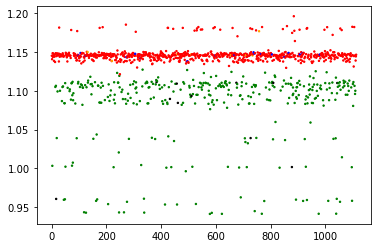

In [172]:
colours = sample['decomposition'].apply(
    lambda x: encode_colour(x)
)

plt.scatter(np.arange(len(sample)), sample.targets, s=2, c=colours)

In [173]:
def encode_colour(decomposition):
    if decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}):
        return 0
    elif decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 126}):
        return 1
    elif decomposition == defaultdict(int, {'Mo1': 64, 'Se1': 1, 'S1': 126} ):
        return 2
    elif decomposition == defaultdict(int, {'Mo1': 64, 'S1': 126}):
        return 3
    elif decomposition == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 127}):
        return 4

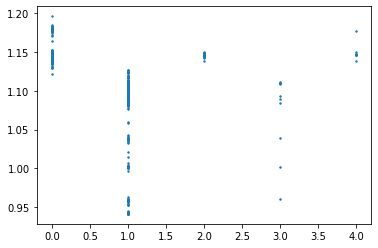

In [175]:
colours = sample['decomposition'].apply(
    lambda x: encode_colour(x)
)

plt.scatter(colours, sample.targets, s=2)

## Class 0

In [184]:
sample = data[data['class'] == 0].copy()
sample.decomposition.value_counts()

TypeError: unhashable type: 'collections.defaultdict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'collections.defaultdict'


{'Mo1': 63, 'Se1': 1, 'S1': 126}    699
{'Mo1': 63, 'Se1': 2, 'S1': 126}    377
{'Mo1': 63, 'S1': 126}              359
{'Mo1': 63, 'S1': 127}                8
{'Mo1': 63, 'Se1': 1, 'S1': 127}      7
{'Mo1': 63, 'S1': 128}                1
Name: decomposition, dtype: int64

In [185]:
def encode_colour(decomposition):
    if decomposition == defaultdict(int, {'Mo1': 63, 'Se1': 1, 'S1': 126}):
        return 'red'
    elif decomposition == defaultdict(int, {'Mo1': 63, 'Se1': 2, 'S1': 126}):
        return 'green'
    elif decomposition == defaultdict(int, {'Mo1': 63, 'S1': 126}):
        return 'blue'
    else:
        return 'black'

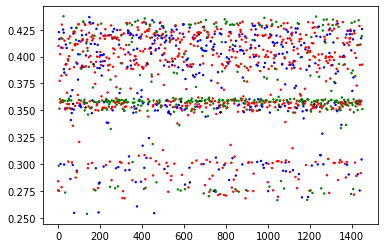

In [186]:
colours = sample['decomposition'].apply(
    lambda x: encode_colour(x)
)

plt.scatter(np.arange(len(sample)), sample.targets, s=2, c=colours)

In [187]:
def encode_colour(decomposition):
    if decomposition == defaultdict(int, {'Mo1': 63, 'Se1': 1, 'S1': 126}):
        return 0
    elif decomposition == defaultdict(int, {'Mo1': 63, 'Se1': 2, 'S1': 126}):
        return 1
    elif decomposition == defaultdict(int, {'Mo1': 63, 'S1': 126}):
        return 2
    else:
        return 3

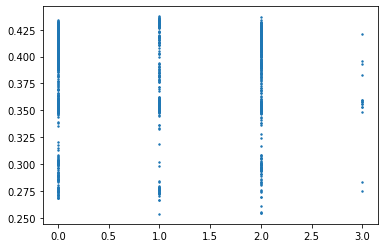

In [188]:
colours = sample['decomposition'].apply(
    lambda x: encode_colour(x)
)

plt.scatter(colours, sample.targets, s=2)

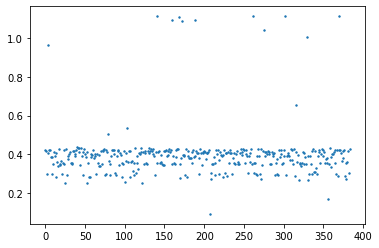

In [192]:
# подкласс класса 0

sample = data[data['len_of_decomposition'] == 2].copy()

plt.scatter(np.arange(len(sample)), sample.targets, s=2)